In [1]:
# find files recursively
from glob import glob

# parse tb files
from tbparse import SummaryReader

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# searching df rows with np.where()
import numpy as np
import pandas as pd

import re

from scipy import stats
import tensorboard as tb
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

2024-10-03 12:48:38.877250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def extract_tb_values(logdir, value_name, print_tags = False):
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()
    
    if print_tags:
        print(event_acc.Tags()['scalars'])
        
    if value_name not in event_acc.Tags()['scalars']:
        print("Scalar not found.")
        return [], [], []
    else:
        events = event_acc.Scalars(value_name)
    
    steps = [event.step for event in events]
    values = [event.value for event in events]
    wall_time = [event.wall_time for event in events]
    
    return values, steps, wall_time

In [3]:
def get_rolling_avg(values, window_size):
    return np.convolve(values, np.ones(window_size) / window_size, mode = 'valid')

In [4]:
def get_names_meeting_env(logdir_list):
    name_list = []
    for file_name in logdir_list:
        name = re.sub("training/custom_spread_training/((s)?\d/)?", "", re.sub("(_\d)?/tensorboard_logs/.*", "",  file_name))
        name_list.append(name)
        
    return name_list

In [5]:
def get_df_in_steps(logdir_list, plot_names, value_name, rolling_avg_window = 1, wall_time_avg = False):
    df = pd.DataFrame()
    
    if wall_time_avg: 
        x = "wall_time"
    else:
        x = "steps"
        
    for (file_name, plot_name) in zip(logdir_list, plot_names):
        values, steps, wall_time = extract_tb_values(file_name, value_name)

        if values != []:
            value_dict = {value_name.replace("reward/", "rollout/"): values, 
                          "steps": steps, 
                          "wall_time": [(time - wall_time[0]) / 60. for time in wall_time]}
            
            temp_df = pd.DataFrame(value_dict)
            
            bin_edges = np.arange(0, temp_df[x].max() + rolling_avg_window, rolling_avg_window, dtype = np.int32)
            temp_df['bin'] = pd.cut(temp_df[x], bins = bin_edges, labels = bin_edges[:-1])

            def weighted_avg(group):
                if not np.isclose(group[x].sum(), 0.):
                    # Calculate the weighted average over the bins weighted by the steps
                    return pd.Series({
                        value_name.replace("reward/", "rollout/"): np.average(group[value_name.replace("reward/", "rollout/")], weights = group[x]),
                    })
                else:
                    return None

            temp_df = temp_df.groupby(['bin'], observed = False)[[value_name.replace("reward/", "rollout/"), "steps", "wall_time", "bin"]].apply(weighted_avg, include_groups = True).reset_index().dropna()
            
            # add missing bins
            all_bins = pd.DataFrame({'bin': bin_edges[:-1]})

            temp_df = pd.merge(all_bins, temp_df, on = 'bin', how = 'left')

            # interpolate missing values
            temp_df[value_name.replace("reward/", "rollout/")] = temp_df[value_name.replace("reward/", "rollout/")].interpolate()
            
            temp_df = temp_df.rename(columns = {"bin": x})
            temp_df["run"] = np.repeat(plot_name, len(temp_df.index))
            
            df = df._append(temp_df)
        
        print(plot_name + " done!")
     
    return df  

In [6]:
def get_tb_files(env_name, run_name_list):
    tb_files = []
    
    for run_name in run_name_list:
        print("training/" + env_name + "/" + run_name + "/**/events*")
        for filename in glob(("training/" + env_name + "/" + run_name + "/**/events*"), recursive=True):
            if "agent" in filename:
                if "agent1" in filename:
                    tb_files.append(filename)
            else:
                tb_files.append(filename)
                
    return tb_files

# 2

In [7]:
run_list = [
    "seqsac_2_1",
    "seqsac_2_2",
    "seqsac_2_3",
    "seqsac_2_4",
    "ssac_2_small",
    "ssac_2_small_2",
    "ssac_2_small_3",
    "ssac_2_small_5",
]
tb_files = get_tb_files("custom_spread_training", run_list)
display(tb_files)

df_2 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/reward_sum", 400)
df_2 = pd.concat([df_2, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 400)])


training/custom_spread_training/seqsac_2_1/**/events*
training/custom_spread_training/seqsac_2_2/**/events*
training/custom_spread_training/seqsac_2_3/**/events*
training/custom_spread_training/seqsac_2_4/**/events*
training/custom_spread_training/ssac_2_small/**/events*
training/custom_spread_training/ssac_2_small_2/**/events*
training/custom_spread_training/ssac_2_small_3/**/events*
training/custom_spread_training/ssac_2_small_5/**/events*


['training/custom_spread_training/seqsac_2_1/tensorboard_logs/events.out.tfevents.1718463207.v100gpu20.311766.0',
 'training/custom_spread_training/seqsac_2_1/tensorboard_logs/train_avg_alpha_loss_agent1/events.out.tfevents.1718463214.v100gpu20.311766.8',
 'training/custom_spread_training/seqsac_2_1/tensorboard_logs/train_avg_actor_loss_agent1/events.out.tfevents.1718463214.v100gpu20.311766.4',
 'training/custom_spread_training/seqsac_2_1/tensorboard_logs/train_avg_alpha_agent1/events.out.tfevents.1718463214.v100gpu20.311766.10',
 'training/custom_spread_training/seqsac_2_1/tensorboard_logs/train_avg_policy_entr_agent1/events.out.tfevents.1718463214.v100gpu20.311766.12',
 'training/custom_spread_training/seqsac_2_1/tensorboard_logs/train_avg_critic_loss_agent1/events.out.tfevents.1718463214.v100gpu20.311766.6',
 'training/custom_spread_training/seqsac_2_1/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1718463208.v100gpu20.311766.2',
 'training/custom_spread_training/seq

Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
Scalar not found.
seqsac_2 done!
seqsac_2 done!
Scalar not found.
ssac_2_small done!
Scalar not found.
ssac_2_small done!
Scalar not found.
ssac_2_small done!
Scalar not found.
ssac_2_small done!


In [8]:

# df_2 = df_2[df_2["steps"] < 40000]

In [9]:
# sns.set_theme()

# fig, ax1 = plt.subplots(figsize = (12, 6))

# ax1.set_xlabel("Episodes")
# sns.lineplot(df_2ep_len[df_2ep_len["run"] == "dqn_7"], x = "steps", y = "rollout/ep_len_avg", color = "tab:blue", label = "Reward (dqn)")
# sns.lineplot(df_2ep_len[df_2ep_len["run"] == "seqdqn_7"], x = "steps", y = "rollout/ep_len_avg", color = "tab:green", label = "Reward (seqdqn)")

# ax2 = ax1.twinx()
# sns.lineplot(df_2[df_2["run"] == "dqn_7"], x = "steps", y = "rollout/eval_reward_sum_avg", color = "tab:red", label = "Episode Length (dqn)", linestyle = "--")
# sns.lineplot(df_2[df_2["run"] == "seqdqn_7"], x = "steps", y = "rollout/eval_reward_sum_avg", color = "tab:orange", label = "Episode Length (seqdqn)", linestyle = "--")
# ax1.tick_params(axis = "y", labelcolor = "tab:red")
# ax2.tick_params(axis = "y", labelcolor = "tab:blue")

# ax2.set_ylabel("Episode Length", color = "tab:red") 
# ax1.set_ylabel("Average Reward", color = "tab:blue")

# ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")

# plt.show()

/tmp/ipykernel_47734/767196086.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)


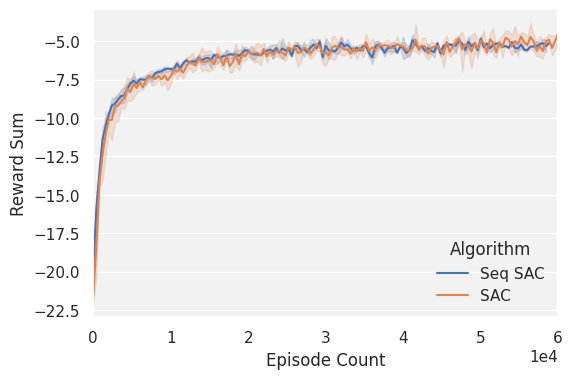

In [10]:
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(df_2[df_2["steps"] <= 60000], x = "steps", y = "rollout/reward_sum", hue = "run", ax = axs)
axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)
axs.grid(axis = "y")
axs.set_ylabel('Reward Sum')
axs.set_xlabel('Episode Count')
axs.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
axs.margins(x=0)

fig.savefig('plots/spread_2.png', dpi = 300, bbox_inches='tight')

# 3

In [11]:
run_list = [
    "seqsac_3_id",
    "seqsac_3_id_2",
    "seqsac_3_id_3",
    "seqsac_3_id_4",
    "seqsac_3_id_5",
    "seqsac_3_id_6",
    "seqsac_3_id_7",
    "seqsac_3_id_8",
    "ssac_3_small",
    "ssac_3_small_2",
    "ssac_3_small_3",
    # "ssac_3_256_small",
]
tb_files = get_tb_files("custom_spread_training", run_list)
display(tb_files)

df_3 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/reward_sum", 400)
df_3 = pd.concat([df_3, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 400)])

training/custom_spread_training/seqsac_3_id/**/events*
training/custom_spread_training/seqsac_3_id_2/**/events*
training/custom_spread_training/seqsac_3_id_3/**/events*
training/custom_spread_training/seqsac_3_id_4/**/events*
training/custom_spread_training/seqsac_3_id_5/**/events*
training/custom_spread_training/seqsac_3_id_6/**/events*
training/custom_spread_training/seqsac_3_id_7/**/events*
training/custom_spread_training/seqsac_3_id_8/**/events*
training/custom_spread_training/ssac_3_small/**/events*
training/custom_spread_training/ssac_3_small_2/**/events*
training/custom_spread_training/ssac_3_small_3/**/events*


['training/custom_spread_training/seqsac_3_id/tensorboard_logs/events.out.tfevents.1727124091.v100gpu20.1760484.0',
 'training/custom_spread_training/seqsac_3_id/tensorboard_logs/train_avg_alpha_loss_agent1/events.out.tfevents.1727124099.v100gpu20.1760484.11',
 'training/custom_spread_training/seqsac_3_id/tensorboard_logs/train_avg_actor_loss_agent1/events.out.tfevents.1727124099.v100gpu20.1760484.5',
 'training/custom_spread_training/seqsac_3_id/tensorboard_logs/train_avg_alpha_agent1/events.out.tfevents.1727124099.v100gpu20.1760484.14',
 'training/custom_spread_training/seqsac_3_id/tensorboard_logs/train_avg_policy_entr_agent1/events.out.tfevents.1727124099.v100gpu20.1760484.17',
 'training/custom_spread_training/seqsac_3_id/tensorboard_logs/train_avg_critic_loss_agent1/events.out.tfevents.1727124099.v100gpu20.1760484.8',
 'training/custom_spread_training/seqsac_3_id/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1727124092.v100gpu20.1760484.2',
 'training/custom_spre

Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
seqsac_3_id done!
Scalar not found.
seqsac_3_id done!
Scalar not found.
seqsac_3_i

/tmp/ipykernel_47734/2897910832.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)


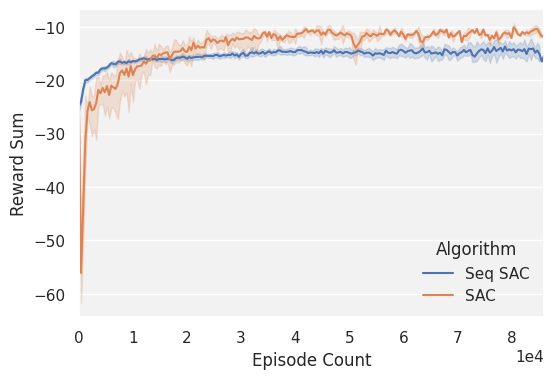

In [20]:
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(df_3[df_3["steps"] <= 86000], x = "steps", y = "rollout/reward_sum", hue = "run", ax = axs)
axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)
axs.grid(axis = "y")
axs.set_ylabel('Reward Sum')
axs.set_xlabel('Episode Count')
axs.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
axs.margins(x=0)

fig.savefig('plots/spread_3.png', dpi = 300, bbox_inches='tight')

# 4

In [13]:
run_list = [
    "seqsac_4_id",
    "seqsac_4_id_2",
    "seqsac_4_id_3",
    "seqsac_4_id_4",
    "ssac_4_small",
    "ssac_4_small_2",
    "ssac_4_small_3",
]
tb_files = get_tb_files("custom_spread_training", run_list)
display(tb_files)

df_4 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/reward_sum", 400)
df_4 = pd.concat([df_4, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 400)])

training/custom_spread_training/seqsac_4_id/**/events*
training/custom_spread_training/seqsac_4_id_2/**/events*
training/custom_spread_training/seqsac_4_id_3/**/events*
training/custom_spread_training/seqsac_4_id_4/**/events*
training/custom_spread_training/ssac_4_small/**/events*
training/custom_spread_training/ssac_4_small_2/**/events*
training/custom_spread_training/ssac_4_small_3/**/events*


['training/custom_spread_training/seqsac_4_id/tensorboard_logs/events.out.tfevents.1727124262.v100gpu19.3007883.0',
 'training/custom_spread_training/seqsac_4_id/tensorboard_logs/train_avg_alpha_loss_agent1/events.out.tfevents.1727124273.v100gpu19.3007883.14',
 'training/custom_spread_training/seqsac_4_id/tensorboard_logs/train_avg_actor_loss_agent1/events.out.tfevents.1727124273.v100gpu19.3007883.6',
 'training/custom_spread_training/seqsac_4_id/tensorboard_logs/train_avg_alpha_agent1/events.out.tfevents.1727124273.v100gpu19.3007883.18',
 'training/custom_spread_training/seqsac_4_id/tensorboard_logs/train_avg_policy_entr_agent1/events.out.tfevents.1727124273.v100gpu19.3007883.22',
 'training/custom_spread_training/seqsac_4_id/tensorboard_logs/train_avg_critic_loss_agent1/events.out.tfevents.1727124273.v100gpu19.3007883.10',
 'training/custom_spread_training/seqsac_4_id/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1727124263.v100gpu19.3007883.2',
 'training/custom_spr

Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
Scalar not found.
seqsac_4_id done!
seqsac_4_id done!
Scalar not found.
ssac_4_small done!
Scalar not found.
ssac_4_sm

/tmp/ipykernel_47734/720198151.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)


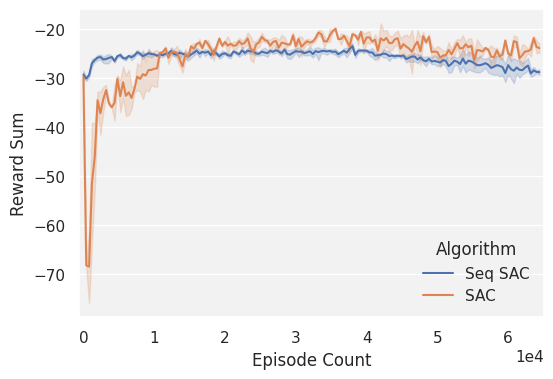

In [18]:
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(1, 1, figsize=(6, 4))
 
sns.lineplot(df_4[df_4["steps"] <= 64600], x = "steps", y = "rollout/reward_sum", hue = "run", ax = axs)
axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)
axs.grid(axis = "y")
axs.set_ylabel('Reward Sum')
axs.set_xlabel('Episode Count')
axs.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
axs.margins(x=0.01)

fig.savefig('plots/spread_4.png', dpi = 300, bbox_inches='tight')